In [5]:
%pylab inline
import nengo
import nengolib


from nengo import LIF

class PerfectLIF(LIF):
    """Spiking version of the leaky integrate-and-fire (LIF) neuron model."""

    def step_math(self, dt, J, spiked, voltage, refractory_time):
        # reduce all refractory times by dt
        refractory_time -= dt

        # compute effective dt for each neuron, based on remaining time.
        # note that refractory times that have completed midway into this
        # timestep will be given a partial timestep, and moreover these will
        # be subtracted to zero at the next timestep (or reset by a spike)
        delta_t = (dt - refractory_time).clip(0, dt)

        # update voltage using discretized lowpass filter
        # since v(t) = v(0) + (J - v(0))*(1 - exp(-t/tau)) assuming
        # J is constant over the interval [t, t + dt)
        voltage -= (J - voltage) * np.expm1(-delta_t / self.tau_rc)

        # determine which neurons spiked (set them to 1/dt, else 0)
        spiked_mask = voltage >= 1
        spiked[:] = spiked_mask / dt
        spiked_v = voltage[spiked_mask]

        # set v(0) = 1 and solve for t to compute the spike time
        t_spike = dt + self.tau_rc * np.log1p(
            -(spiked_v - 1) / (J[spiked_mask] - 1))

        # set spiked voltages to zero, refractory times to tau_ref, and
        # rectify negative voltages to a floor of min_voltage
        voltage[voltage < self.min_voltage] = self.min_voltage
        voltage[spiked_mask] = 0
        refractory_time[spiked_mask] = self.tau_ref + t_spike


T = 20.0
dt = 0.002
seed = 6

n_neurons = 1000
neuron_type = PerfectLIF()

tau_recurrent = 0.050
scale_input = 5 # * (0.001 / dt)
tau_stim = 0.1
tau_probe = 0.005

A, B, C, D, = nengolib.synapses.ss2sim(
    ~nengolib.signal.s, nengo.Lowpass(tau_recurrent), dt=dt)
print A, B
assert np.allclose(C, 1)
assert np.allclose(D, 0)

with nengo.Network(seed=seed) as model:
    x = nengo.Ensemble(n_neurons, 1, neuron_type=neuron_type)

    #noise = nengo.Node(output=1.0/scale_input)
    noise = nengo.Node(output=nengo.processes.WhiteSignal(T))
    #noise = nengo.Node(output=lambda t: np.sin(20*np.pi*t))
    
    
    stim = nengo.Node(size_in=1)
    nengo.Connection(noise, stim, synapse=tau_stim, transform=scale_input)
    
    nengo.Connection(stim, x, synapse=tau_recurrent, transform=B)
    nengo.Connection(x, x, synapse=tau_recurrent, transform=A)
    
    p_input = nengo.Probe(stim, synapse=tau_probe)
    p_output = nengo.Probe(x, synapse=tau_probe)
    p_spikes = nengo.Probe(x.neurons)

sim = nengo.Simulator(model, dt=dt, seed=seed)

import time
start = time.time()
sim.run(T)
print time.time() - start


Populating the interactive namespace from numpy and matplotlib
[[ 1.]] [[ 0.05100667]]
Simulation finished in 0:00:02.                                                 
1.97000002861


`%matplotlib` prevents importing * from pylab and numpy


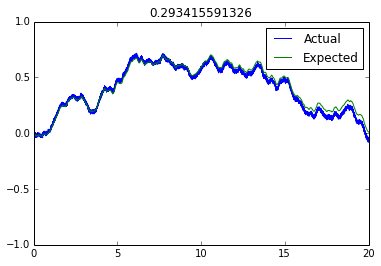

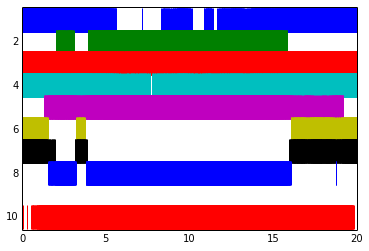

In [6]:
from nengo.utils.matplotlib import rasterplot
from nengo.utils.numpy import rmse

t = (sim.trange() > 0) #& (sim.trange() < 0.6) # (sim.trange() > 1.8) & (sim.trange() < 2.0)

actual = sim.data[p_output][t]
expected = (cumsum(sim.data[p_input])*dt)[t]
#expected = sim.data[p_input][t]

figure()
title(rmse(actual, expected))
ylim(-1, 1)
plot(sim.trange()[t], actual, label="Actual")
plot(sim.trange()[t], expected, label="Expected")
legend()
show()


figure()
rasterplot(sim.trange()[t], sim.data[p_spikes][t][:, 0:10])
show()

In [6]:
nengo.utils.matplotlib.rasterplot

<function nengo.utils.matplotlib.rasterplot>

In [4]:
from nengo.utils.matplotlib import rasterplot

In [5]:
nengo.utils.matplotlib.rasterplot

<function nengo.utils.matplotlib.rasterplot>